In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import re
from scipy.fftpack import dct, idct
from scipy.optimize import minimize
from sklearn import linear_model
from scipy.stats import pearsonr, spearmanr
import importlib

def importlib_reload(lib_name):
    importlib.reload(sys.modules[lib_name])

# sys.path.append(os.path.join('..','UTILS'))
# from cosamp_fn import cosamp
# cosamp function is available at https://github.com/avirmaux/CoSaMP
# copy function from ipynb into cosamp_fn.py and place in UTILS folder

# plt.rcParams['figure.figsize'] = [12, 12]
# plt.rcParams.update({'font.size': 18})

In [3]:
import pandas as pd
import networkx as nx
from sklearn.utils import shuffle
from collections import Counter

from QAOAKit import (
    opt_angles_for_graph,
    get_fixed_angles,
    get_graph_id,
    get_graph_from_id,
    angles_to_qaoa_format,
    beta_to_qaoa_format,
    gamma_to_qaoa_format,
    angles_to_qiskit_format,
    angles_to_qtensor_format,
    get_3_reg_dataset_table,
    get_3_reg_dataset_table_row,
    get_full_qaoa_dataset_table_row,
    get_full_qaoa_dataset_table,
    get_fixed_angle_dataset_table,
    get_fixed_angle_dataset_table_row,
    qaoa_maxcut_energy,
    noisy_qaoa_maxcut_energy,
    angles_from_qiskit_format,

)

from QAOAKit.compressed_sensing import (
    cosamp,
    one_D_CS_p1_recon_with_given_landscapes_and_varing_sampling_frac,
    recon_by_Lasso
)



In [4]:
# def recon_by_Lasso(Theta, y, alpha=0.1):
#     n = Theta.shape[1]
#     lasso = linear_model.Lasso(alpha=alpha)# here, we use lasso to minimize the L1 norm
#     # lasso.fit(Theta, y.reshape((M,)))
#     lasso.fit(Theta, y)
#     # Plotting the reconstructed coefficients and the signal
#     # Creates the fourier transform that will most minimize l1 norm 
#     recons = idct(lasso.coef_.reshape((n, 1)), axis=0)
#     recons += lasso.intercept_
#     return recons

In [26]:
def cal_recon_error(x, x_recon, residual_type):
    # print(x.shape, x_recon.shape)

    assert len(x.shape) == 1 or len(x.shape) == 2 and x.shape[1] == 1
    assert len(x_recon.shape) == 1 or len(x_recon.shape) == 2 and x_recon.shape[1] == 1

    x = x.reshape(-1)
    x_recon = x_recon.reshape(-1)

    diff = x - x_recon

    if residual_type == 'MIN_MAX':
        res = np.sqrt((diff ** 2).mean()) / (x.max() - x.min())
    elif residual_type == 'MEAN':
        res = np.sqrt((diff ** 2).mean()) / x.mean()
    elif residual_type == 'MSE':
        res = np.sqrt((diff ** 2).mean())
    elif residual_type == 'CROSS_CORRELATION':
        res = np.correlate(x_recon, x, mode='valid')
        # print(res)
        # assert np.isclose(res[0], np.sum(x_recon * x))
        res = res[0] / np.sqrt(np.sum(x_recon ** 2) * np.sum(x ** 2))
    elif residual_type == 'CONV':
        # print(x_recon.shape)
        # print(x_recon.shape, x.shape)
        res = np.convolve(x_recon, x) # take x as filter
        # print(res)
        res = res[0]
        # assert np.isclose(res[0])
        # return res[0]
    elif residual_type == 'ZNCC':
        res = 0
        # res = np.sum((x_recon - x_recon.mean()) * (x - x.mean())) / np.sqrt(x_recon.var() * x.var())
    else:
        assert f"Invalid residual_type {residual_type}"

    return res


def cal_recon_error_of_exp_full_landscapes(
    data_dir,
    residual_type,
    sampling_frac,
    alpha
):
    data = np.load(f"{data_dir}/data.npz", allow_pickle=True)

    origin = data['origin'].tolist() 
    recon = one_D_CS_p1_recon_with_given_landscapes_and_varing_sampling_frac(
        figdir=None,
        origin=origin,
        full_range=data['full_range'].tolist(),
        n_pts=data['n_pts'].tolist(),
        sampling_frac=sampling_frac,
        alpha=alpha
    )
    # print(recon)

    # calculate rows by rows
    # print(recon['ideals'])
    n_rows = recon['ideals'].shape[0]

    _LABELS = ['mitis', 'unmitis', 'ideals']
    # recon_es = {label: [] for label in _LABELS}
    recon_e = {label: 0.0 for label in _LABELS}

    for i in range(n_rows):
        for label, _ in recon.items():
            error = cal_recon_error(origin[label][i,:], recon[label][i,:], residual_type)
            # print(error)
            recon_e[label] += error
    
    # print(recon_e)
    for label, _ in recon_e.items():
        recon_e[label] /= n_rows
    
    return recon_e

n_pts:  {'beta': 56, 'gamma': 226}
n_samples:  {'beta': 6, 'gamma': 23}
alpha:  0.1
start: solve l1 norm


/Users/kunliu/miniforge3/envs/py39_mitiq/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.796e-03, tolerance: 8.065e-04
  model = cd_fast.enet_coordinate_descent(
/Users/kunliu/miniforge3/envs/py39_mitiq/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.238e-04, tolerance: 6.921e-04
  model = cd_fast.enet_coordinate_descent(
/Users/kunliu/miniforge3/envs/py39_mitiq/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

end: solve l1 norm
n_pts:  {'beta': 56, 'gamma': 226}
n_samples:  {'beta': 8, 'gamma': 30}
alpha:  0.1
start: solve l1 norm
end: solve l1 norm
n_pts:  {'beta': 56, 'gamma': 226}
n_samples:  {'beta': 9, 'gamma': 37}
alpha:  0.1
start: solve l1 norm


/Users/kunliu/miniforge3/envs/py39_mitiq/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.683e-03, tolerance: 1.913e-03
  model = cd_fast.enet_coordinate_descent(
/Users/kunliu/miniforge3/envs/py39_mitiq/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.559e-03, tolerance: 1.792e-03
  model = cd_fast.enet_coordinate_descent(
/Users/kunliu/miniforge3/envs/py39_mitiq/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

end: solve l1 norm
n_pts:  {'beta': 56, 'gamma': 226}
n_samples:  {'beta': 11, 'gamma': 43}
alpha:  0.1
start: solve l1 norm
end: solve l1 norm
n_pts:  {'beta': 56, 'gamma': 226}
n_samples:  {'beta': 13, 'gamma': 50}
alpha:  0.1
start: solve l1 norm


/Users/kunliu/miniforge3/envs/py39_mitiq/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.549e-03, tolerance: 3.545e-03
  model = cd_fast.enet_coordinate_descent(
/Users/kunliu/miniforge3/envs/py39_mitiq/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.937e-03, tolerance: 3.106e-03
  model = cd_fast.enet_coordinate_descent(
/Users/kunliu/miniforge3/envs/py39_mitiq/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

end: solve l1 norm
n_pts:  {'beta': 56, 'gamma': 226}
n_samples:  {'beta': 14, 'gamma': 57}
alpha:  0.1
start: solve l1 norm
end: solve l1 norm
n_pts:  {'beta': 56, 'gamma': 226}
n_samples:  {'beta': 16, 'gamma': 64}
alpha:  0.1
start: solve l1 norm
end: solve l1 norm
n_pts:  {'beta': 56, 'gamma': 226}
n_samples:  {'beta': 18, 'gamma': 71}
alpha:  0.1
start: solve l1 norm
end: solve l1 norm
n_pts:  {'beta': 56, 'gamma': 226}
n_samples:  {'beta': 20, 'gamma': 77}
alpha:  0.1
start: solve l1 norm
end: solve l1 norm
n_pts:  {'beta': 56, 'gamma': 226}
n_samples:  {'beta': 21, 'gamma': 84}
alpha:  0.1
start: solve l1 norm
end: solve l1 norm
n_pts:  {'beta': 56, 'gamma': 226}
n_samples:  {'beta': 23, 'gamma': 91}
alpha:  0.1
start: solve l1 norm
end: solve l1 norm
n_pts:  {'beta': 56, 'gamma': 226}
n_samples:  {'beta': 25, 'gamma': 98}
alpha:  0.1
start: solve l1 norm
end: solve l1 norm
n_pts:  {'beta': 56, 'gamma': 226}
n_samples:  {'beta': 26, 'gamma': 104}
alpha:  0.1
start: solve l1 norm

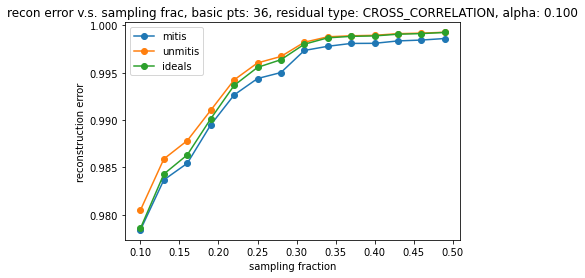

In [32]:
def plot_recon_error_vs_sf():
    # vary sampling fractions
    data_dir = "figs/cnt_opt_miti/2022-08-08_19:48:31/G30_nQ8_p1_sf0.050"
    # data_dir = "figs/cnt_opt_miti/2022-08-08_19:48:31/G30_nQ8_p1_sf0.080"
    # data_dir = "figs/cnt_opt_miti/2022-08-08_19:48:31/G30_nQ8_p1_sf0.110"
    sfs = np.arange(0.1, 0.5, 0.03)
    # sfs = np.arange(0.05, 0.1, 0.03)
    # sfs = np.arange(0.1, 0.51, 0.03)

    # n_tries = 1
    # basic_pts = 36
    # alpha = 0.001
    # is_vis = True
    # basic_pts_list = [36, 100, 1000,]

    basic_pts = 36
    alpha = 0.1
    is_vis = True
    # residual_type = 'CONV'
    residual_type = 'CROSS_CORRELATION'
    # residual_type = 'ZNCC'
    # residual_type = 'MSE'

    # n_tries = 1
    # basic_pts = 1000
    # alpha = 0.1
    # is_vis = True
    _LABELS = ['mitis', 'unmitis', 'ideals']
    # for basic_pts in basic_pts_list
    recon_es = {label: [] for label in _LABELS}
    for sf in sfs:

        recon_e = cal_recon_error_of_exp_full_landscapes(
            data_dir,
            residual_type,
            sf,
            alpha)

        # print(recon_e)
        for label, error in recon_e.items():
            # print(error)
            recon_es[label].append(error)

    fig, axs = plt.subplots()
    for label, errors in recon_es.items():
        axs.plot(sfs, errors, marker='o', label=label)
    axs.legend()
    axs.set_xlabel('sampling fraction')
    axs.set_ylabel('reconstruction error')
    axs.set_title(f'recon error v.s. sampling frac, basic pts: {basic_pts}, residual type: {residual_type}, alpha: {alpha:.3f}')
    plt.show()

importlib_reload('QAOAKit.compressed_sensing')
plot_recon_error_vs_sf()

NameError: name 'vary_sf' is not defined

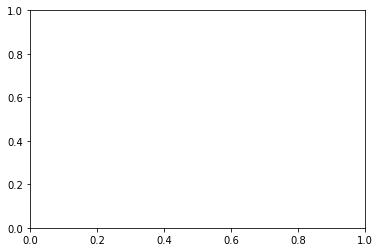

In [20]:
# vary sampling fractions
# sfs = np.arange(0.1, 0.5, 0.03)
sfs = np.arange(0.05, 0.5, 0.03)
# sfs = np.arange(0.1, 0.51, 0.03)

basic_pts_list = [36, 100, 1000, 1500]

n_tries = 100
alpha = 0.01
is_vis = False
# residual_type = 'CONV'
residual_type = 'CROSS_CORRELATION'
# residual_type = 'MSE'

fig, axs = plt.subplots()

for basic_pts in basic_pts_list:
    recon_es = []
    for sf in sfs:
        error = 0
        for _ in range(n_tries):
            error += vary_sf(sf,
                residual_type=residual_type,
                basic_pts=basic_pts,
                is_vis=is_vis,
                alpha=alpha)
        recon_es.append(error / n_tries)

    axs.plot(sfs, recon_es, marker='o', label=f"basic_pts={basic_pts}")
axs.legend()
axs.set_xlabel('sampling fraction')
axs.set_ylabel('reconstruction error')
axs.set_title('reconstruction error v.s. sampling fraction')
plt.show()

/Users/kunliu/miniforge3/envs/py39_mitiq/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/Users/kunliu/miniforge3/envs/py39_mitiq/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/Users/kunliu/miniforge3/envs/py39_mitiq/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

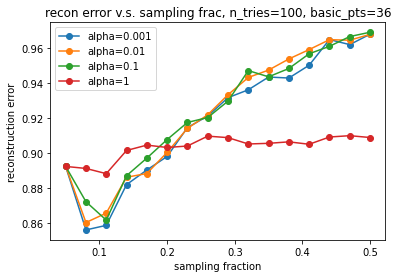

In [96]:
# vary sampling fractions
# sfs = np.arange(0.1, 0.5, 0.03)
sfs = np.arange(0.05, 0.5, 0.03)
# sfs = np.arange(0.1, 0.51, 0.03)

alphas = [0.001, 0.01, 0.1, 1]

n_tries = 100
is_vis = False
basic_pts = 36
# residual_type = 'CONV'
residual_type = 'CROSS_CORRELATION'

fig, axs = plt.subplots()

for alpha in alphas:
    recon_es = []
    for sf in sfs:
        error = 0
        for _ in range(n_tries):
            error += vary_sf(sf,
                residual_type=residual_type,
                basic_pts=basic_pts,
                is_vis=is_vis,
                alpha=alpha)
        recon_es.append(error / n_tries)

    axs.plot(sfs, recon_es, marker='o', label=f"alpha={alpha}")
axs.legend()
axs.set_xlabel('sampling fraction')
axs.set_ylabel('reconstruction error')
axs.set_title(f'recon error v.s. sampling frac, n_tries={n_tries}, basic_pts={basic_pts}')
plt.show()

In [49]:
## Randomly sample signal
p = 128 # num. random samples, p = n/32
perm = np.floor(np.random.rand(p) * n).astype(int)
y = x[perm]
print(perm)

[1742 2219  902  363  777 2477 2975 2667 3326 2476 1030  540 2646 2982
 2503 3679  168 2556 1273  397  581 1425 1785 1586 2176  790 3882 2864
 1116  425 2429 1429 1530 1728 1552 3028 3598 2813 2504 1412  296 3863
 2805 1378 1438 1334  130 1420 2822 1720 3750 3259 2756  545 2391 2881
   47 1273 2384 3542 1875 2521 3791 1585 2153 3043 2398 1901 2660  877
  875 1417 3742  828  348  130 1846  612 1339 2637 1503 2196 1812 2775
 3575 3988 3706 1838 3023  292 1659  235 3785 3901  638 2516 1626 2815
 3162 3436  177 3045 2310 2781  300  676 2850  907  127 3149 1035  687
 3064 1293 1415 2791 1346  212  788 1460 1216 2561 1298 1028  302  325
 1514 3077]


In [50]:
## Solve compressed sensing problem
Psi = dct(np.identity(n)) # Build Psi
Theta = Psi[perm,:]       # Measure rows of Psi

# s = cosamp(Theta,y,10,epsilon=1.e-10,max_iter=10) # CS via matching pursuit
# xrecon = idct(s) # reconstruct full signal

In [51]:
# xrecon = cnt_opt_by_cs(x)
xrecon = recon_by_Lasso(Theta, y)

/Users/kunliu/miniforge3/envs/py39_mitiq/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


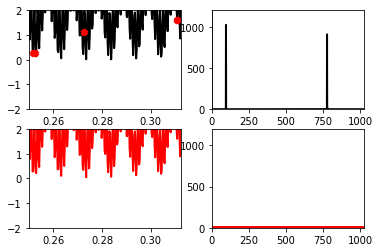

In [52]:
## Plot
time_window = np.array([1024,1280])/4096
freq = np.arange(n)
L = int(np.floor(n/2))


fig,axs = plt.subplots(2,2)
axs = axs.reshape(-1)

axs[1].plot(freq[:L],PSD[:L],color='k',linewidth=2)
axs[1].set_xlim(0, 1024)
axs[1].set_ylim(0, 1200)

axs[0].plot(t,x,color='k',linewidth=2)
axs[0].plot(perm/n,y,color='r',marker='x',linewidth=0,ms=5,mew=4)
axs[0].set_xlim(time_window[0],time_window[1])
axs[0].set_ylim(-2, 2)

axs[2].plot(t,xrecon,color='r',linewidth=2)
axs[2].set_xlim(time_window[0],time_window[1])
axs[2].set_ylim(-2, 2)

xtrecon = np.fft.fft(xrecon,n) # computes the (fast) discrete fourier transform
PSDrecon = xtrecon * np.conj(xtrecon)/n # Power spectrum (how much power in each freq)

axs[3].plot(freq[:L],PSDrecon[:L],color='r',linewidth=2)
axs[3].set_xlim(0, 1024)
axs[3].set_ylim(0, 1200)

plt.show()

In [28]:
## L1-Minimization using SciPy
def L1_norm(x):
    return np.linalg.norm(x,ord=1)

constr = ({'type': 'eq', 'fun': lambda x:  Theta @ x - y})
x0 = np.linalg.pinv(Theta) @ y 
res = minimize(L1_norm, x0, method='SLSQP',constraints=constr)
s = res.x
xrecon = idct(s)

In [8]:
print(s)

[-0.00061083  0.00170517 -0.00165844 ...  0.00034396 -0.00308204
 -0.00065701]


In [13]:
Theta.shape

(128, 4096)

In [14]:
y.shape

(128,)

In [58]:
unmitis = []
unmitis_recon = []
# for i in range(4):
data = np.load("figs/cnt_opt_miti/2022-07-23_14:32:44/G31_nQ8_p2/varIdx3.npz", allow_pickle=True)
unmitis = data['unmitis']
unmitis_recon = data['unmitis_recon']
print(unmitis, unmitis_recon)


[5.61767578 6.51464844 3.92578125 ... 8.16552734 5.65673828 4.42578125] [4.2239904  4.22398825 4.22398395 ... 2.0861718  2.0861675  2.08616535]


In [73]:
def draw_PSD(x):
    n = x.shape[0]
    freq = np.arange(n)
    # L = int(np.floor(n/2))
    L = 10

    fig, axs = plt.subplots()
    xt = np.fft.fft(x, n) # computes the (fast) discrete fourier transform
    PSD = xt * np.conj(xt) / n # Power spectrum (how much power in each freq)

    # axs.set_xlim(0, 1024)
    axs.set_ylim(0, 1024)
    axs.plot(freq[1:L], PSD[1:L], color='r', linewidth=2)
    plt.show()

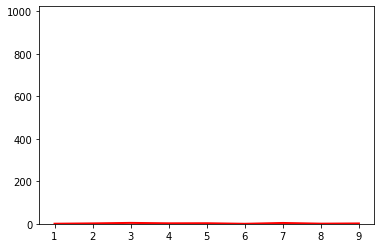

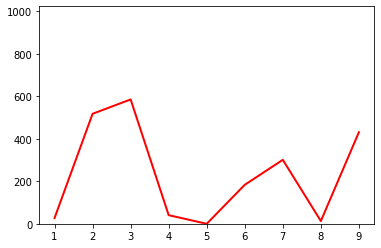

In [74]:
draw_PSD(unmitis)
draw_PSD(unmitis_recon)